In [92]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import fontManager

#Colab ÈÄ≤Ë°åmatplotlibÁπ™ÂúñÊôÇÈ°ØÁ§∫ÁπÅÈ´î‰∏≠Êñá
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud


--2023-08-29 11:54:45--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.197.138, 74.125.197.102, 74.125.197.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ufvun6amir31vm78jfr2c7p9f6eeg6b9/1693310025000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=5f711193-c212-4b2d-91e7-c114308e08eb [following]
--2023-08-29 11:54:48--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ufvun6amir31vm78jfr2c7p9f6eeg6b9/1693310025000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=5f711193-c212-4b2d-91e7-c114308e08eb
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [93]:
API_KEY = 'Input your key here'

In [94]:
channel_ids = ['UCvTe3Z7TZsjGzUERx4Ce6zA',
        # more channels here
        ]
#To get the channel id, you can use this link: https://commentpicker.com/youtube-channel-id.php

In [95]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
  api_service_name, api_version, developerKey = API_KEY)

In [96]:
def get_channel_stats(youtube, channel_ids):

  all_data = []

  request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=",".join(channel_ids)
  )
  response = request.execute()

  # loop through items
  for item in response['items']:
      data = {'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalVideos': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
      }

      all_data.append(data)

  return pd.DataFrame(all_data)

In [97]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [98]:
channel_stats

channelName subscribers      views totalVideos                playlistId
0  ÊîùÂæíÊó•Ë®òFun TV      782000  407355671        1386  UUvTe3Z7TZsjGzUERx4Ce6zA

In [99]:
playlistId="UUvTe3Z7TZsjGzUERx4Ce6zA"

def get_video_ids(youtube, playlist_id):

    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    #Âõ†ÁÇ∫maxResultsÂè™ËÉΩÊúÄÂ§öÊèêÂèñ50ÂÄãResultÔºåÂõ†Ê≠§ÈúÄË¶ÅÁî®while loop‰∏ÄÁõ¥ÊêúÂ∞ãÂà∞ÊúÄÂæå‰∏ÄÈ†ÅÔºåÁç≤ÂèñÂÖ®ÈÉ®video id
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')

    return video_ids

In [100]:
video_ids = get_video_ids(youtube, playlistId)
len(video_ids)

1314

In [101]:
def get_video_details(youtube, video_ids):

    all_video_info = []
    #Âõ†ÁÇ∫APIÈôêÂà∂Ôºå‰∏ÄÊ¨°ÊúÄÂ§öÂè™ÂèØ‰ª•ÊèêÂèñ50ÂÄãÁµêÊûúÔºåÊâÄ‰ª•for loopÈúÄË¶ÅÊØè50Ë∑≥
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [102]:
video_df = get_video_details(youtube, video_ids)
video_df

video_id channelTitle  \
0     7CgCIP7kvwI   ÊîùÂæíÊó•Ë®òFun TV   
1     U95BGyC_3XI   ÊîùÂæíÊó•Ë®òFun TV   
2     V4Ep9EKdECc   ÊîùÂæíÊó•Ë®òFun TV   
3     kva5IDKUWxI   ÊîùÂæíÊó•Ë®òFun TV   
4     kGWuSgHe4Yo   ÊîùÂæíÊó•Ë®òFun TV   
...           ...          ...   
1309  CdjbKWoLQT0   ÊîùÂæíÊó•Ë®òFun TV   
1310  b3esFwRBLtY   ÊîùÂæíÊó•Ë®òFun TV   
1311  Fdh52HvQBOo   ÊîùÂæíÊó•Ë®òFun TV   
1312  Wi7NAlypr0c   ÊîùÂæíÊó•Ë®òFun TV   
1313  KLPLP824oQo   ÊîùÂæíÊó•Ë®òFun TV   

                                                  title  \
0         ÂèçÈßÅÂ∞èÁ≤âÁ¥ÖÂøÖÁúãÔºÅ‰∏≠ÂúãÈõÜÈ´îÈ≠îÂæÅ‚ãØÈõªË©±È®∑ÊìæÊó•Êú¨Â∫óÂÆ∂‚ãØÂéªÊó•Ê†°ÊâîÁü≥È†≠‚ãØËÄÅÈóÜÂóÜÔºöÊú¨Â∫óÈ£üÊùê‰æÜËá™Á¶èÂ≥∂Âª¢Ê∞¥   
1                                            ‰∏≠ÂúãÈπΩËçíÂ≠êÂ≠´ÁöÑÈÄÜË•≤ÔºÅ   
2                                   Â∞èÁ≤âÁ¥ÖÂóÜÊó•Êú¨ÊéíÂª¢Ê∞¥‚ãØÂ§ßÂì≠#shorts   
3                 ÊâìËáâ‰∏≠ÂúãÁßëÊôÆÁ∂≤Á¥ÖÔºÅÂè∞ÁÅ£‰∫∫Âø´ÂñùÊó•Êú¨Âª¢Ê∞¥‚ãØÂ∞èÁ≤âÁ¥ÖË∑≥Ê∞¥ÂèçÊó•‚ãØÈπΩËçíÂ≠êÂ≠´‰∏ÄÂ§©ÂêÉ‰∏âÂÖ¨Êñ§   
4                    Â∞èÁ≤âÁ¥ÖÂ∞∑Â∞¨ÁßÄÔºÅ‰∏≠ÂúãÂÖ´ÈÉ®ÊÅ•Â∫¶ÁâπËºØ‚ãØÈõÜÈ´îÂ§ßÈ¨ßÊó•Êú¨‚ãØÂè∞ÁÅ£‰∫∫ÂøÉËáü‰∏çÂ§†Âº∑Âà•Áúã‚ãØ   
...                                                 ...   
1309                „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÊñ∞ÂüéÊùë5Â§ßÁßòÂ¢ÉÔΩúÁ´ãÈúßÊ∫™Âá∫Êµ∑Âè£ÊØîÂÅ∂ÂÉèÂäáÂ†¥ÊôØÈÇÑÁæé   
1310  „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂ§™È≠ØÈñ£ÁôΩÊ•äÊ≠•ÈÅìÊ∞¥ÊøÇÊ¥û [Taiwan Travel ] Huali...   
1311                             Ëä±ËìÆÊ¥ªÂãïÔΩú2018Â§™È≠ØÈñ£Èü≥Ê®ÇÁ•≠ÔΩúÂ§öÂÖÉÊ∞ëÊóèÂÖ±Ëûç   
1312                      „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂ±¨ÊñºËä±ËìÆÊñáÈùíÁöÑÂçöÊÑõÁâπÂçÄÔΩúÂç≥Â∞áÁÜÑÁáà   
1313            „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂÖ®Âè∞ÊúÄÁæéÊòüÂ∑¥ÂÖãÔΩú Âéü‰ΩèÊ∞ëÂúñÈ®∞Ë≤®Ê´ÉÂ±ãÊàêÁÇ∫Ëä±ËìÆ‰∫∫Ê∞£Êñ∞ÊôØÈªû   

                                            description  \
0     ÂèçÈßÅÂ∞èÁ≤âÁ¥ÖÂøÖÁúãÔºÅ‰∏≠ÂúãÈõÜÈ´îÈ≠îÂæÅ‚ãØÈõªË©±È®∑ÊìæÊó•Êú¨Â∫óÂÆ∂‚ãØÂéªÊó•Ê†°ÊâîÁü≥È†≠‚ãØËÄÅÈóÜÂóÜÔºöÊú¨Â∫óÈ£üÊùê‰æÜËá™Á¶èÂ≥∂Âª¢Ê∞¥\...   
1     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
2     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
3     ÊâìËáâ‰∏≠ÂúãÁßëÊôÆÁ∂≤Á¥ÖÔºÅÊ†∏Ê±ôÊ∞¥Ë∑üÊ†∏Âª¢Ê∞¥ÂçÄÂà•Âú®Âì™ÔºüË¶ÅÁõ∏‰ø°‰∏ñÁïåÂéüÂ≠êÂ∞àÂÆ∂ÂÄëÁöÑË©±ÔºåÈÇÑÊòØ‰∏ÄÂÄã‰∏âÂπ¥ÈÉΩÂú®‰∫ÇÊêûÁâπËâ≤...   
4     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
...                                                 ...   
1309  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nÊõºÊ≥¢È≠öÁöÑÊïÖÈÑâÔºåÊñ∞ÂüéÊùëÁöÑÁç®ÂÆ∂Êé®Ëñ¶\nÂæÄÂæÄÂ§ßÂÆ∂ÊâÄÁÜüÊÇâÁöÑÊñ∞ÂüéÂè™ÊúÉÊÉ≥Âà∞‰∏É...   
1310  Âú®Â§™È≠ØÈñ£Â§©Á••Â±±ÂçÄ‰∏çÈÅ†ËôïÁöÑÁôΩÊ•äÊ≠•ÈÅìÊ∞¥ÊøÇÊ¥û\nÂ∞ÅÈñâ1Âπ¥Â§öÂæåÔºåÂú®10Êúà28Êó•ÈáçÊñ∞ÈñãÊîæ\nÂ§èÂ§©‰æÜÂà∞Â±±...   
1311  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°åÁöÑ‰∏ªÊåÅ‰∫∫\nÊú¨Ë∫´Èô§‰∫ÜÊòØÈÅìÂú∞ÁöÑËä±ËìÆ‰∫∫‰πãÂ§ñ\nÊõ¥ÊòØÂ§™È≠ØÈñ£ÊóèÁöÑ‰∏ÄÂì°\nÈÄôÊ¨°‰ªãÁ¥π...   
1312  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nË∂ïÂú®10/31ÁµêÊùüÁáüÊ•≠ÂâçÔºå‰æÜÊãçÊîùÂçöÊÑõÁâπÂçÄ\nÁ¥ÄÈåÑ‰ªñÊúÄÂæåÁöÑÁæéË≤åÔºåÁµ¶...   
1313  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nËä±ËìÆÂêâÂÆâÈÑâ Ê¥ÑÁÄæË≤®Ê´ÉÂ±ãÊòüÂ∑¥ÂÖãÈñÄÂ∏Ç\nÊ¥ÑÁÄæÈñÄÂ∏ÇÂùêËêΩÊñºËøéÊé•Â§™Âπ≥Ê¥ãÈù¢Âçá...   

                                                   tags           publishedAt  \
0     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÂÖ´ÁÇØ Â∞èÁ≤âÁ¥Ö, ÊîùÂæíÊó•Ë®ò Â∞èÁ≤âÁ¥Ö]  2023-08-29T11:54:39Z   
1                       [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ]  2023-08-29T06:03:43Z   
2                       [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ]  2023-08-28T15:03:55Z   
3     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÈóúÈçµÊôÇÂàª, ÂÖ´ÁÇØ Â∞èÁ≤âÁ∫¢, ...  2023-08-28T12:46:23Z   
4     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÈóúÈçµÊôÇÂàª, ÂÖ´ÁÇØ Â∞èÁ≤âÁ∫¢, ...  2023-08-27T12:16:34Z   
...                                                 ...                   ...   
1309  [Ëä±ËìÆ, ÊôØÈªû, Êñ∞Âüé, ‰∏ÉÊòüÊΩ≠, Ê™∏Ê™¨Ê±Å, Â§©‰∏ªÂ†Ç, ÊóÖÈÅä, vlog, ÁßòÂ¢É, taiw...  2018-11-12T11:00:02Z   
1310  [Â§™È≠ØÈñ£, Ëä±ËìÆ, Ê∞¥ÊøÇÊ¥û, ÁôΩÊ

## Data pre-processing

In [103]:
video_df.isnull().any() #check for NULL values

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [104]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [105]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [106]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [107]:
pip install isodate

In [108]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [109]:
video_df[['durationSecs', 'duration']]

durationSecs  duration
0            838.0  PT13M58S
1             28.0     PT28S
2             48.0     PT48S
3            795.0  PT13M15S
4            794.0  PT13M14S
...            ...       ...
1309         293.0   PT4M53S
1310         291.0   PT4M51S
1311         301.0    PT5M1S
1312          80.0   PT1M20S
1313          80.0   PT1M20S

[1314 rows x 2 columns]

In [110]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [111]:
video_df

video_id channelTitle  \
0     7CgCIP7kvwI   ÊîùÂæíÊó•Ë®òFun TV   
1     U95BGyC_3XI   ÊîùÂæíÊó•Ë®òFun TV   
2     V4Ep9EKdECc   ÊîùÂæíÊó•Ë®òFun TV   
3     kva5IDKUWxI   ÊîùÂæíÊó•Ë®òFun TV   
4     kGWuSgHe4Yo   ÊîùÂæíÊó•Ë®òFun TV   
...           ...          ...   
1309  CdjbKWoLQT0   ÊîùÂæíÊó•Ë®òFun TV   
1310  b3esFwRBLtY   ÊîùÂæíÊó•Ë®òFun TV   
1311  Fdh52HvQBOo   ÊîùÂæíÊó•Ë®òFun TV   
1312  Wi7NAlypr0c   ÊîùÂæíÊó•Ë®òFun TV   
1313  KLPLP824oQo   ÊîùÂæíÊó•Ë®òFun TV   

                                                  title  \
0         ÂèçÈßÅÂ∞èÁ≤âÁ¥ÖÂøÖÁúãÔºÅ‰∏≠ÂúãÈõÜÈ´îÈ≠îÂæÅ‚ãØÈõªË©±È®∑ÊìæÊó•Êú¨Â∫óÂÆ∂‚ãØÂéªÊó•Ê†°ÊâîÁü≥È†≠‚ãØËÄÅÈóÜÂóÜÔºöÊú¨Â∫óÈ£üÊùê‰æÜËá™Á¶èÂ≥∂Âª¢Ê∞¥   
1                                            ‰∏≠ÂúãÈπΩËçíÂ≠êÂ≠´ÁöÑÈÄÜË•≤ÔºÅ   
2                                   Â∞èÁ≤âÁ¥ÖÂóÜÊó•Êú¨ÊéíÂª¢Ê∞¥‚ãØÂ§ßÂì≠#shorts   
3                 ÊâìËáâ‰∏≠ÂúãÁßëÊôÆÁ∂≤Á¥ÖÔºÅÂè∞ÁÅ£‰∫∫Âø´ÂñùÊó•Êú¨Âª¢Ê∞¥‚ãØÂ∞èÁ≤âÁ¥ÖË∑≥Ê∞¥ÂèçÊó•‚ãØÈπΩËçíÂ≠êÂ≠´‰∏ÄÂ§©ÂêÉ‰∏âÂÖ¨Êñ§   
4                    Â∞èÁ≤âÁ¥ÖÂ∞∑Â∞¨ÁßÄÔºÅ‰∏≠ÂúãÂÖ´ÈÉ®ÊÅ•Â∫¶ÁâπËºØ‚ãØÈõÜÈ´îÂ§ßÈ¨ßÊó•Êú¨‚ãØÂè∞ÁÅ£‰∫∫ÂøÉËáü‰∏çÂ§†Âº∑Âà•Áúã‚ãØ   
...                                                 ...   
1309                „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÊñ∞ÂüéÊùë5Â§ßÁßòÂ¢ÉÔΩúÁ´ãÈúßÊ∫™Âá∫Êµ∑Âè£ÊØîÂÅ∂ÂÉèÂäáÂ†¥ÊôØÈÇÑÁæé   
1310  „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂ§™È≠ØÈñ£ÁôΩÊ•äÊ≠•ÈÅìÊ∞¥ÊøÇÊ¥û [Taiwan Travel ] Huali...   
1311                             Ëä±ËìÆÊ¥ªÂãïÔΩú2018Â§™È≠ØÈñ£Èü≥Ê®ÇÁ•≠ÔΩúÂ§öÂÖÉÊ∞ëÊóèÂÖ±Ëûç   
1312                      „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂ±¨ÊñºËä±ËìÆÊñáÈùíÁöÑÂçöÊÑõÁâπÂçÄÔΩúÂç≥Â∞áÁÜÑÁáà   
1313            „ÄêËä±ËìÆÊóÖÈÅäÊîªÁï•„ÄëËä±ËìÆÊôØÈªûÔΩúÂÖ®Âè∞ÊúÄÁæéÊòüÂ∑¥ÂÖãÔΩú Âéü‰ΩèÊ∞ëÂúñÈ®∞Ë≤®Ê´ÉÂ±ãÊàêÁÇ∫Ëä±ËìÆ‰∫∫Ê∞£Êñ∞ÊôØÈªû   

                                            description  \
0     ÂèçÈßÅÂ∞èÁ≤âÁ¥ÖÂøÖÁúãÔºÅ‰∏≠ÂúãÈõÜÈ´îÈ≠îÂæÅ‚ãØÈõªË©±È®∑ÊìæÊó•Êú¨Â∫óÂÆ∂‚ãØÂéªÊó•Ê†°ÊâîÁü≥È†≠‚ãØËÄÅÈóÜÂóÜÔºöÊú¨Â∫óÈ£üÊùê‰æÜËá™Á¶èÂ≥∂Âª¢Ê∞¥\...   
1     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
2     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
3     ÊâìËáâ‰∏≠ÂúãÁßëÊôÆÁ∂≤Á¥ÖÔºÅÊ†∏Ê±ôÊ∞¥Ë∑üÊ†∏Âª¢Ê∞¥ÂçÄÂà•Âú®Âì™ÔºüË¶ÅÁõ∏‰ø°‰∏ñÁïåÂéüÂ≠êÂ∞àÂÆ∂ÂÄëÁöÑË©±ÔºåÈÇÑÊòØ‰∏ÄÂÄã‰∏âÂπ¥ÈÉΩÂú®‰∫ÇÊêûÁâπËâ≤...   
4     üì∫Ô∏èÈ†ªÈÅìÊúÉÂì°Ôºöhttps://www.youtube.com/channel/UCvTe3Z...   
...                                                 ...   
1309  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nÊõºÊ≥¢È≠öÁöÑÊïÖÈÑâÔºåÊñ∞ÂüéÊùëÁöÑÁç®ÂÆ∂Êé®Ëñ¶\nÂæÄÂæÄÂ§ßÂÆ∂ÊâÄÁÜüÊÇâÁöÑÊñ∞ÂüéÂè™ÊúÉÊÉ≥Âà∞‰∏É...   
1310  Âú®Â§™È≠ØÈñ£Â§©Á••Â±±ÂçÄ‰∏çÈÅ†ËôïÁöÑÁôΩÊ•äÊ≠•ÈÅìÊ∞¥ÊøÇÊ¥û\nÂ∞ÅÈñâ1Âπ¥Â§öÂæåÔºåÂú®10Êúà28Êó•ÈáçÊñ∞ÈñãÊîæ\nÂ§èÂ§©‰æÜÂà∞Â±±...   
1311  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°åÁöÑ‰∏ªÊåÅ‰∫∫\nÊú¨Ë∫´Èô§‰∫ÜÊòØÈÅìÂú∞ÁöÑËä±ËìÆ‰∫∫‰πãÂ§ñ\nÊõ¥ÊòØÂ§™È≠ØÈñ£ÊóèÁöÑ‰∏ÄÂì°\nÈÄôÊ¨°‰ªãÁ¥π...   
1312  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nË∂ïÂú®10/31ÁµêÊùüÁáüÊ•≠ÂâçÔºå‰æÜÊãçÊîùÂçöÊÑõÁâπÂçÄ\nÁ¥ÄÈåÑ‰ªñÊúÄÂæåÁöÑÁæéË≤åÔºåÁµ¶...   
1313  ÊîùÂæíÊó•Ë®ò-89ÂéªÊóÖË°å\n\nËä±ËìÆÂêâÂÆâÈÑâ Ê¥ÑÁÄæË≤®Ê´ÉÂ±ãÊòüÂ∑¥ÂÖãÈñÄÂ∏Ç\nÊ¥ÑÁÄæÈñÄÂ∏ÇÂùêËêΩÊñºËøéÊé•Â§™Âπ≥Ê¥ãÈù¢Âçá...   

                                                   tags  \
0     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÂÖ´ÁÇØ Â∞èÁ≤âÁ¥Ö, ÊîùÂæíÊó•Ë®ò Â∞èÁ≤âÁ¥Ö]   
1                       [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ]   
2                       [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ]   
3     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÈóúÈçµÊôÇÂàª, ÂÖ´ÁÇØ Â∞èÁ≤âÁ∫¢, ...   
4     [‰∏≠Âúã, ‰∏≠ÂÖ±, ÊîùÂæíÊó•Ë®ò, ÂÖ´ÁÇØ, Â∞èÁ≤âÁ¥Ö, Âè∞ÁÅ£, Ë®≠Âúñ, ÈóúÈçµÊôÇÂàª, ÂÖ´ÁÇØ Â∞èÁ≤âÁ∫¢, ...   
...                                                 ...   
1309  [Ëä±ËìÆ, ÊôØÈªû, Êñ∞Âüé, ‰∏ÉÊòüÊΩ≠, Ê™∏Ê™¨Ê±Å, Â§©‰∏ªÂ†Ç, ÊóÖÈÅä, vlog, ÁßòÂ¢É, taiw...   
1310  [Â§™È≠ØÈñ£, Ëä±ËìÆ, Ê∞¥ÊøÇÊ¥û, ÁôΩÊ•äÊ≠•ÈÅì, ÊóÖÈÅä, ÊóÖË°å, ÁßòÂ¢É, hualien, taiw...   
1311  [Â§™È≠ØÈñ£, Èü≥Ê®ÇÁ•≠, Ëä±ËìÆ, Âè∞ÁÅ£, VLOG, ÊóÖÈÅä, ÊóÖË°å, ÊôØÈªû, Ëä±ËìÆÊôØÈªû, Êñ∞Âüé,...   
1312  [Ëä±ËìÆ, ÊñáÈ

## Best performing videos

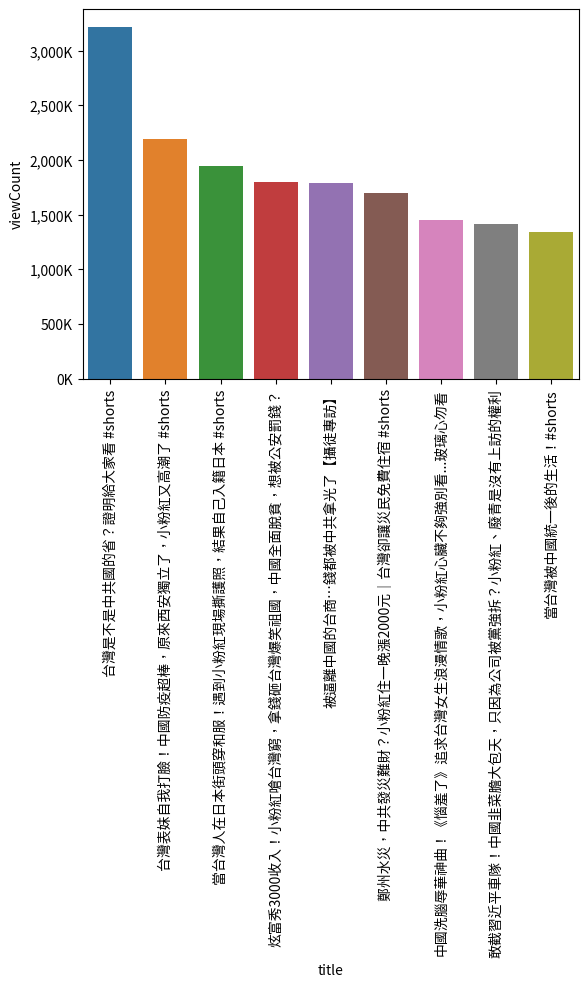

In [112]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Worst performing videos

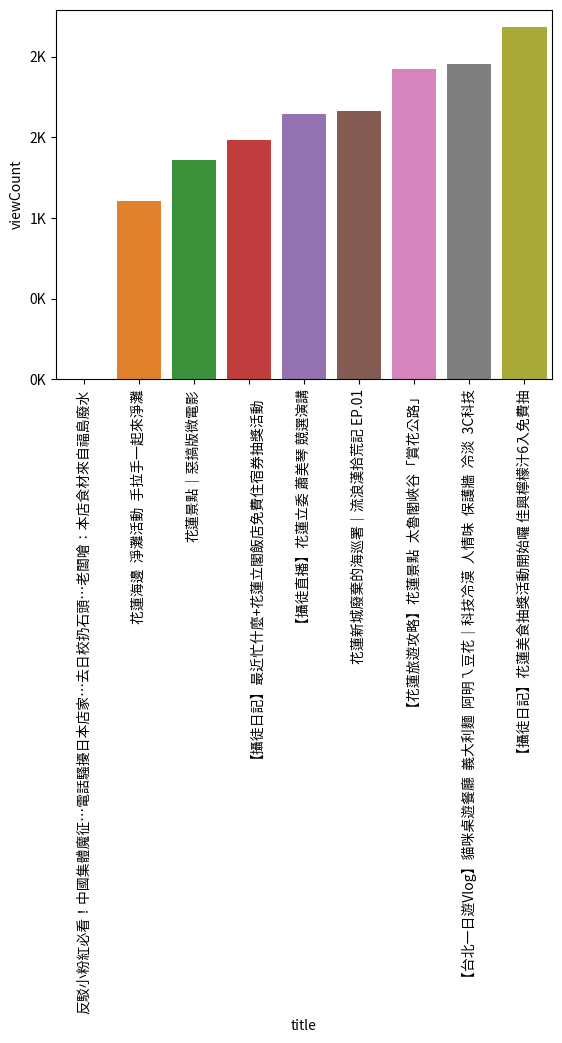

In [113]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## View distribution per video

<Axes: xlabel='channelTitle', ylabel='viewCount'>

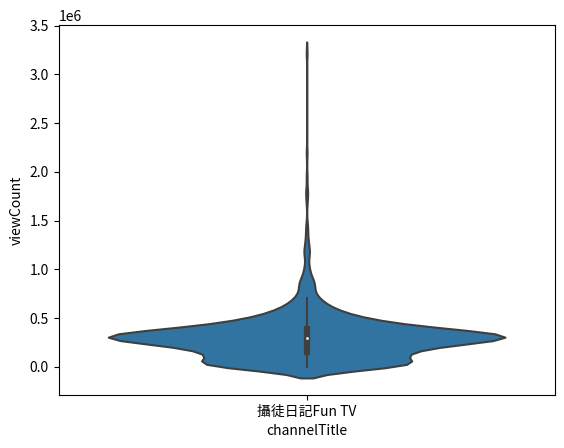

In [114]:
sns.violinplot(x=video_df['channelTitle'],y=video_df['viewCount']) #Violin plot for the channel

## Views vs. likes and comments

<Axes: xlabel='likeCount', ylabel='viewCount'>

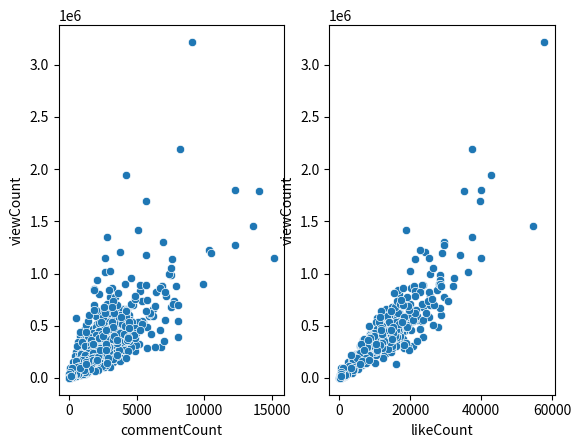

In [115]:
# get the relationship between viewCount and commentCount as well as likeCount
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

## Video duration

<Axes: xlabel='durationSecs', ylabel='Count'>

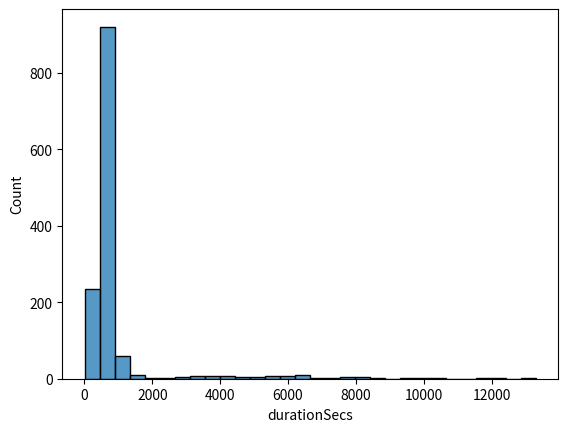

In [116]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

## Wordcloud for video titles in Chinese

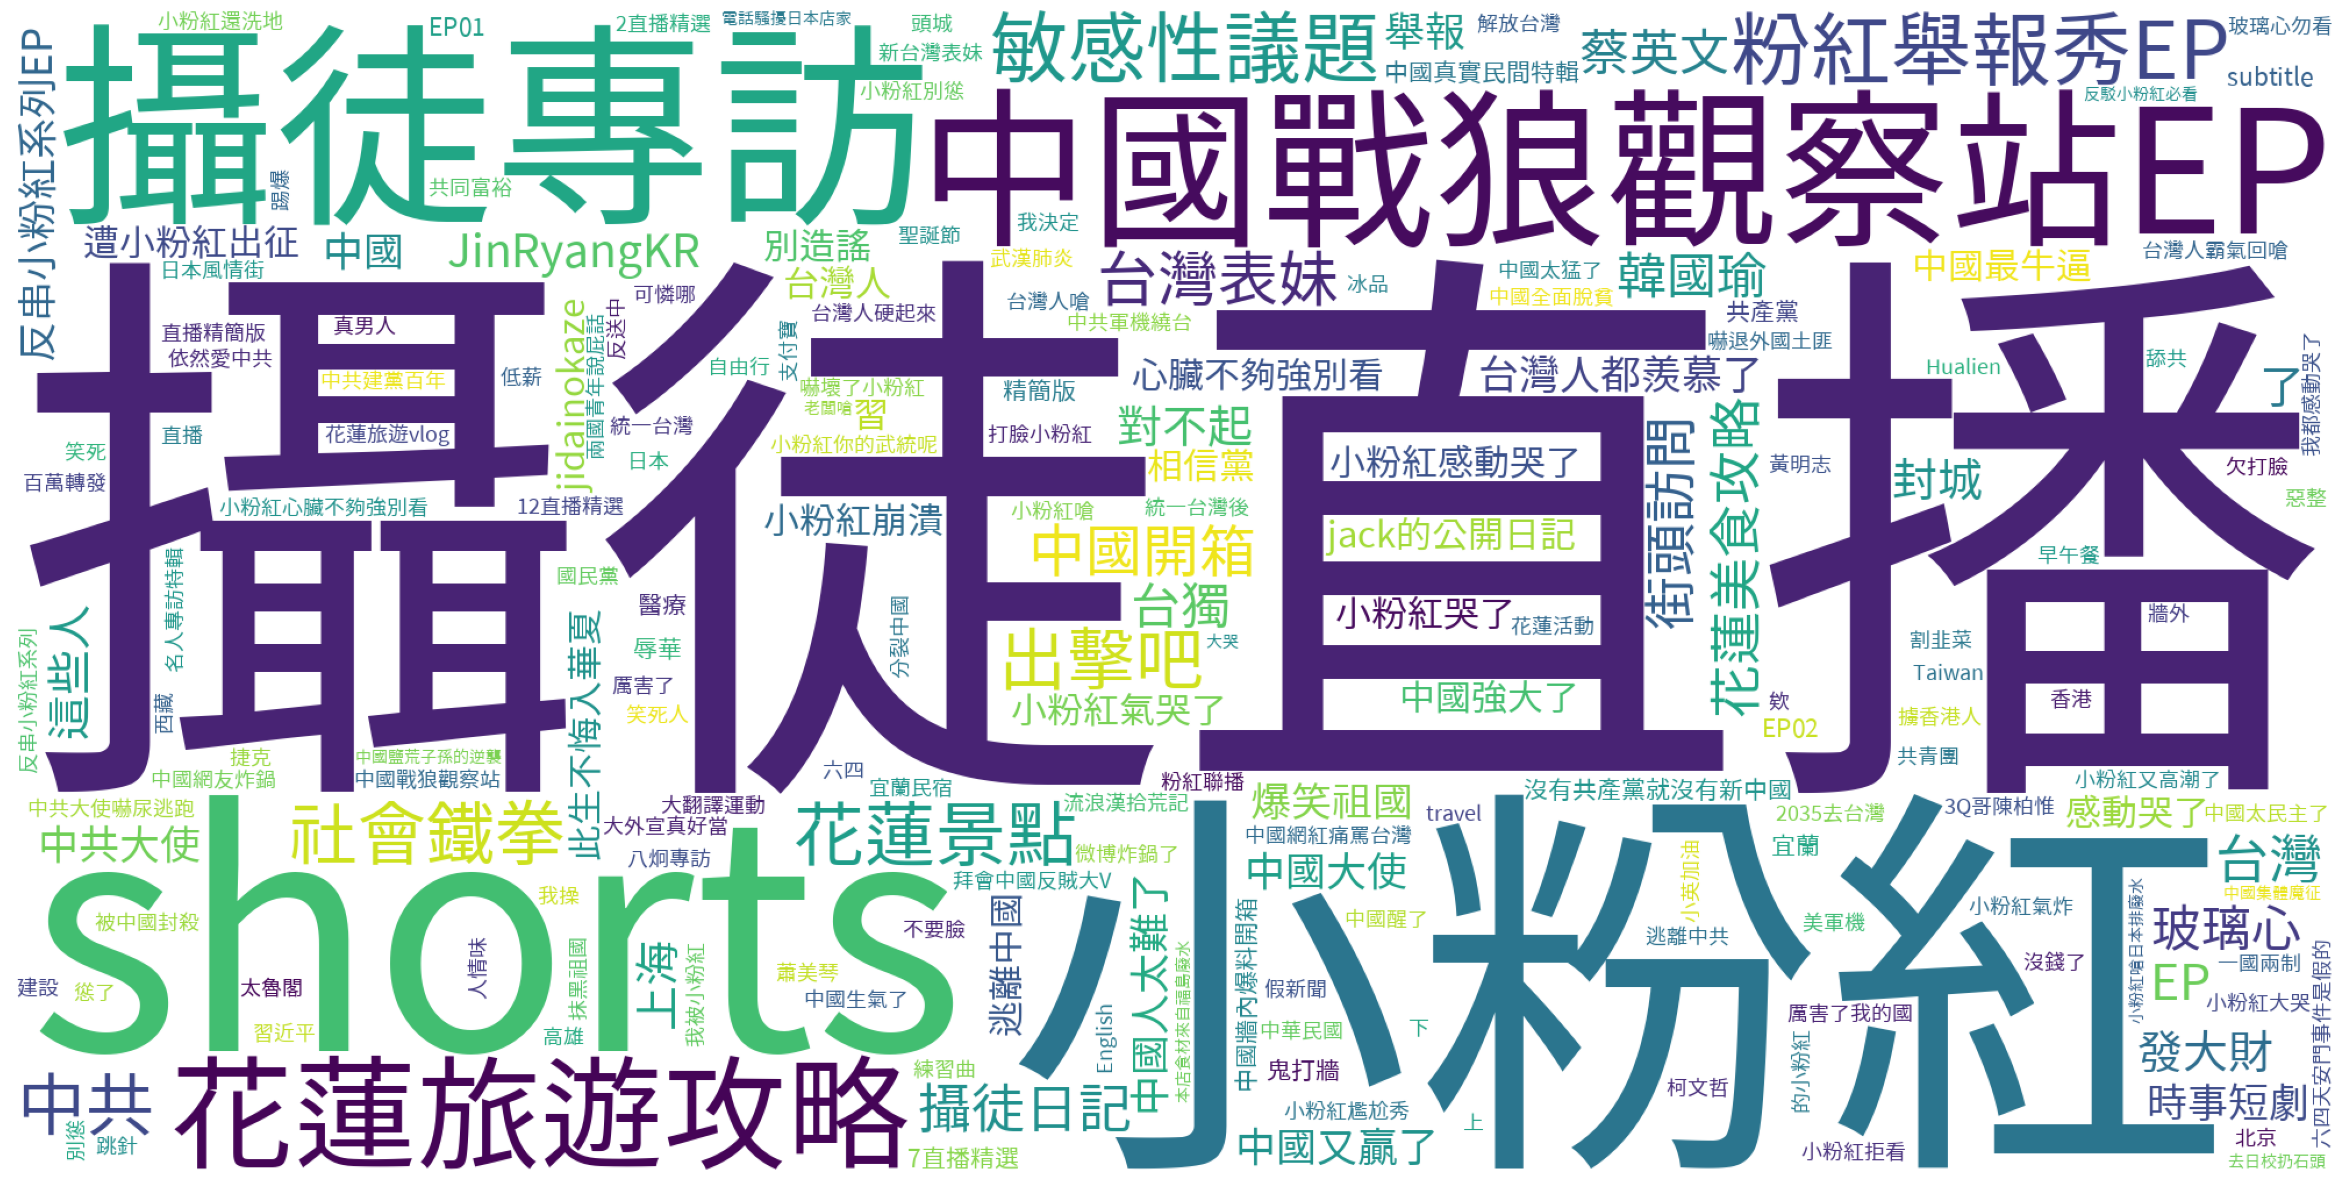

In [117]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='white',
                      colormap='viridis', collocations=False, font_path="TaipeiSansTCBeta-Regular.ttf").generate(all_words_str)
#Because that is Chinese Youtube Channel, we need to change the font_path to support Traditional Chinese
plot_cloud(wordcloud)

## Upload schedule

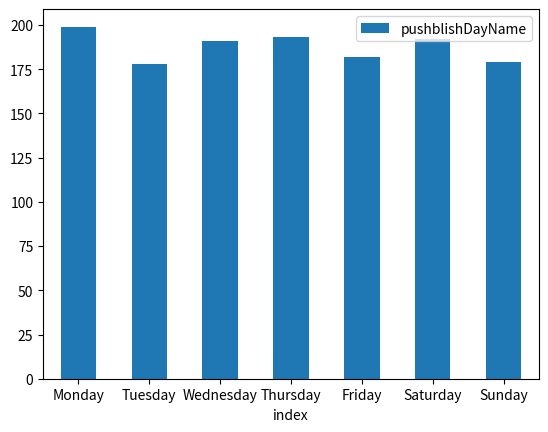

In [118]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)